# RUNE: A Complete Interpretation Showcase

This notebook serves as a comprehensive tutorial and demonstration for every function within the `rune.interpret` module. We will first train a small suite of representative models from the `rune` library. Then, we will use these trained models to showcase each interpretation tool, explaining its purpose and how to read the output.

**Goal:** To provide a clear, practical example for every public interpretation function available in the `rune` library.

**Models to be Interpreted:**
1.  `InterpretableRuneNet`: The core sequential model.
2.  `PrototypeRuneNet`: The case-based reasoning model.
3.  `PairwiseDifferenceNet`: A simpler model to showcase specific layer visualizations.
4.  `CyclicTropicalDifferenceNet`: To demonstrate its unique projection layer visualization.

In [1]:
!pip install git+https://github.com/EmotionEngineer/rune.git

  Cloning https://github.com/EmotionEngineer/rune.git to /tmp/pip-req-build-8we18u26
  Running command git clone --filter=blob:none --quiet https://github.com/EmotionEngineer/rune.git /tmp/pip-req-build-8we18u26
  Resolved https://github.com/EmotionEngineer/rune.git to commit 86517bb55a889498fc2906cedd9a016356dda45f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.4 MB/s e

In [2]:
# ==============================================================================
# Section 1: Setup and Library Imports
# ==============================================================================
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_wine
import time
import copy
import json
from tqdm.notebook import tqdm
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
sns.set_theme(style="whitegrid")

# --- Import from the RUNE library ---
# If this fails, run: !pip install git+https://github.com/EmotionEngineer/rune.git
try:
    from rune.models import (
        InterpretableRuneNet, 
        PrototypeRuneNet, 
        PairwiseDifferenceNet,
        CyclicTropicalDifferenceNet
    )
    from rune.interpret import (
        plot_pairwise_difference_weights,
        plot_tropical_aggregator_params,
        plot_gated_aggregator_gates,
        plot_linear_weights,
        plot_cyclic_layer_projection_weights,
        plot_feature_interaction_graph,
        plot_final_layer_contributions,
        analyze_tropical_dominance,
        trace_decision_path,
        analyze_prototype_prediction,
        plot_prototypes_with_tsne,
    )
except ImportError as e:
    raise ImportError(f"Could not import from rune. Please install it first:\n!pip install git+https://github.com/EmotionEngineer/rune.git\nOriginal error: {e}")

# Global Configurations
LEARNING_RATE = 0.001
EPOCHS = 3000 # Reduced epochs for faster showcase running
BATCH_SIZE = 32
PATIENCE = 500
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


## Section 2: Training Infrastructure
This section contains the necessary functions to load data and train our models. These trained models will serve as the subjects for our interpretation deep-dive.

In [3]:
def get_data(dataset_name='wine'):
    data = load_wine()
    X, y, feature_names = data.data, data.target, data.feature_names
    
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    scaler = StandardScaler().fit(X_train_raw)
    X_train = scaler.transform(X_train_raw)
    X_test = scaler.transform(X_test_raw)

    train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    
    input_dim = X.shape[1]
    output_dim = len(set(y))
    
    return DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True), (X_test, y_test), scaler, feature_names, input_dim, output_dim

def train_model(model, train_loader, epochs=EPOCHS, patience=PATIENCE):
    model.to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    loss_fn = nn.CrossEntropyLoss()
    
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in tqdm(range(epochs), desc=f"Training {model.__class__.__name__}", leave=False):
        model.train()
        
        current_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            current_loss += loss.item()
        
        avg_loss = current_loss / len(train_loader)
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            break
            
    model.eval()
    return model

## Section 3: Model Training
We train one of each key model type. These instances will be used in the interpretation section.

In [4]:
# Load data
train_loader, (X_test, y_test), scaler, feature_names, input_dim, output_dim = get_data()

# Define and train models
print("--- Training Models for Interpretation Showcase ---")
base_kwargs = {"input_dim": input_dim, "output_dim": output_dim}

irn_model = train_model(InterpretableRuneNet(**base_kwargs, num_blocks=2, block_dim=16), train_loader)
proto_model = train_model(PrototypeRuneNet(**base_kwargs, num_prototypes=8, num_blocks=1, block_dim=12), train_loader)
pdn_model = train_model(PairwiseDifferenceNet(**base_kwargs, hidden_dims=[20], interpretable_head=True), train_loader)
ctdn_model = train_model(CyclicTropicalDifferenceNet(**base_kwargs, projection_dim=8, hidden_dims=[16], use_angle_encoding=True, interpretable_head=True), train_loader)

print("--- All models trained ---")

--- Training Models for Interpretation Showcase ---


Training InterpretableRuneNet:   0%|          | 0/3000 [00:00<?, ?it/s]

Training PrototypeRuneNet:   0%|          | 0/3000 [00:00<?, ?it/s]

Training PairwiseDifferenceNet:   0%|          | 0/3000 [00:00<?, ?it/s]

Training CyclicTropicalDifferenceNet:   0%|          | 0/3000 [00:00<?, ?it/s]

--- All models trained ---


## Section 4: A Complete Tour of `rune.interpret`

In this section, we will call every major function from the `rune.interpret` module, using the models we just trained. Each subsection will explain the function's purpose and show its output.

### 4.1. Visualizing Simple Layer Weights
These functions inspect the parameters of individual, basic layers.

#### `plot_linear_weights`

Visualizes the weight matrix of any `nn.Linear` layer. Here, we inspect the input projection layer of our `InterpretableRuneNet`, showing how original features are mapped into the model's hidden space.

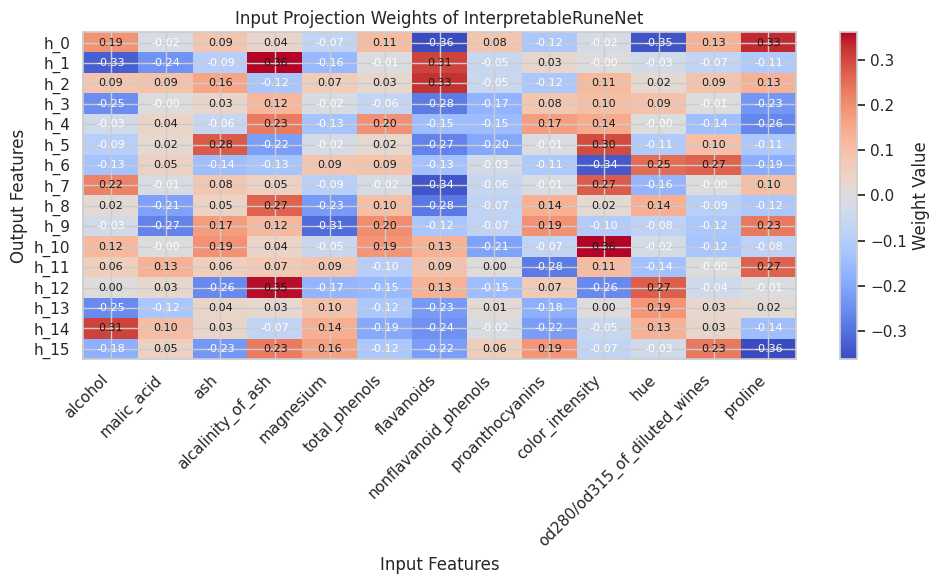

In [5]:
display(Markdown("#### `plot_linear_weights`"))
display(Markdown("Visualizes the weight matrix of any `nn.Linear` layer. Here, we inspect the input projection layer of our `InterpretableRuneNet`, showing how original features are mapped into the model's hidden space."))

fig, ax = plt.subplots(figsize=(10, 6))
plot_linear_weights(
    irn_model.input_projection,
    feature_names_in=feature_names,
    feature_names_out=[f"h_{i}" for i in range(irn_model.input_projection.out_features)],
    ax=ax,
    title="Input Projection Weights of InterpretableRuneNet"
)
plt.show()

#### `plot_pairwise_difference_weights`

Shows the learned importance of each `(feature_i - feature_j)` comparison in a `PairwiseDifferenceLayer`. This is useful for simple models that use this explicit feature engineering step.

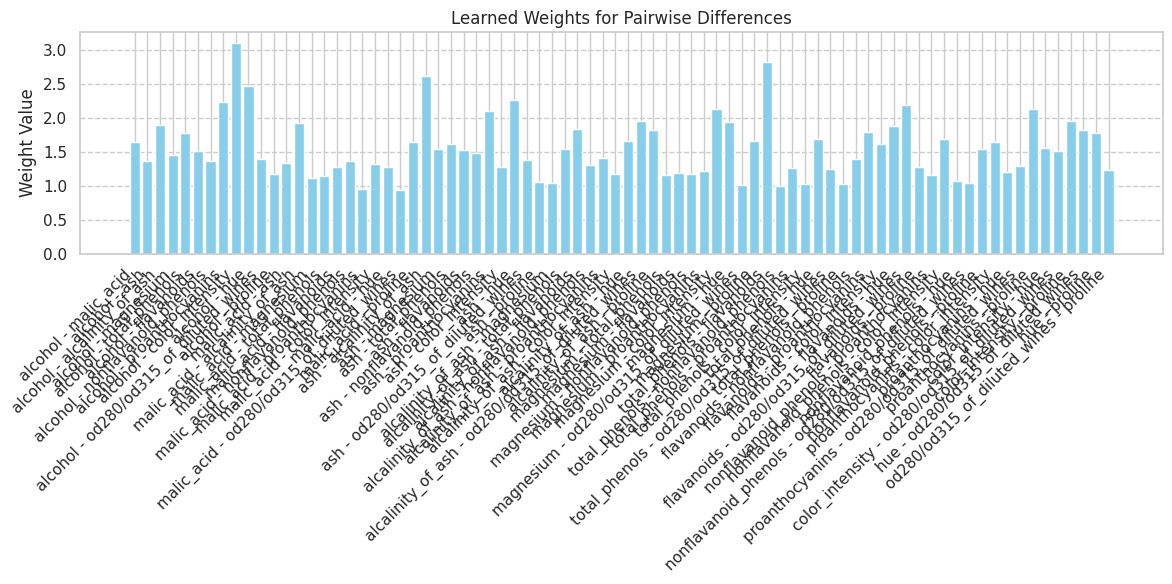

In [6]:
display(Markdown("#### `plot_pairwise_difference_weights`"))
display(Markdown("Shows the learned importance of each `(feature_i - feature_j)` comparison in a `PairwiseDifferenceLayer`. This is useful for simple models that use this explicit feature engineering step."))

fig, ax = plt.subplots(figsize=(12, 6))
plot_pairwise_difference_weights(
    pdn_model.pairwise_diff_layer,
    feature_names=feature_names,
    ax=ax,
    title="Learned Weights for Pairwise Differences"
)
plt.show()

#### `plot_cyclic_layer_projection_weights`

A convenience wrapper for `plot_linear_weights`, specifically for the projection layer inside a `CyclicTropicalDifferenceLayer`. It visualizes how input features are projected before the cyclic transformation.

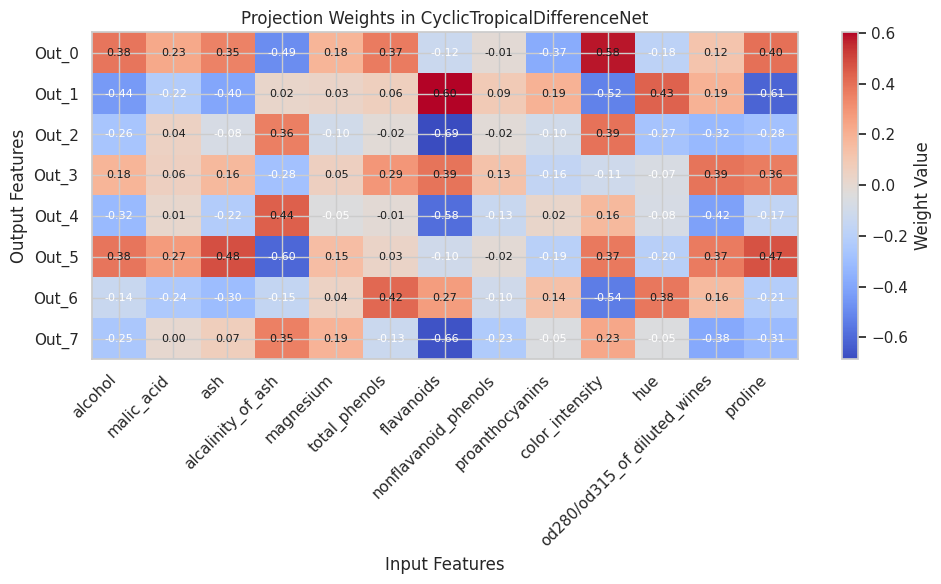

In [7]:
display(Markdown("#### `plot_cyclic_layer_projection_weights`"))
display(Markdown("A convenience wrapper for `plot_linear_weights`, specifically for the projection layer inside a `CyclicTropicalDifferenceLayer`. It visualizes how input features are projected before the cyclic transformation."))

fig, ax = plt.subplots(figsize=(10, 6))
plot_cyclic_layer_projection_weights(
    ctdn_model.cyclic_tropical_diff_layer,
    feature_names_in=feature_names,
    title="Projection Weights in CyclicTropicalDifferenceNet",
    ax=ax  # <-- THE FIX IS HERE
)
plt.show()

### 4.2. Deconstructing RUNE Blocks
These functions allow us to look inside the core components of `InterpretableRuneNet`.

#### `plot_tropical_aggregator_params`

Visualizes the key interaction weights (`W_ij`) inside a `TropicalDifferenceAggregator`. This heatmap reveals which pairwise comparisons of hidden features the model relies on most heavily.

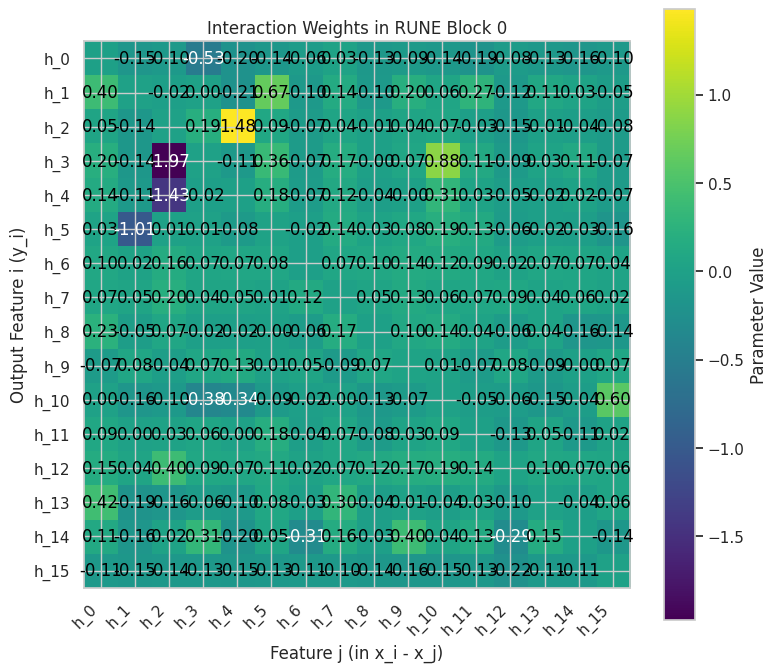

In [8]:
display(Markdown("#### `plot_tropical_aggregator_params`"))
display(Markdown("Visualizes the key interaction weights (`W_ij`) inside a `TropicalDifferenceAggregator`. This heatmap reveals which pairwise comparisons of hidden features the model relies on most heavily."))

# Let's inspect the first RUNE block in our trained InterpretableRuneNet
block0 = irn_model.rune_blocks[0]
hidden_dim = block0.gated_agg.dim
hidden_names = [f'h_{i}' for i in range(hidden_dim)]

fig, ax = plt.subplots(figsize=(8, 7))
plot_tropical_aggregator_params(
    block0.gated_agg.tropical_agg,
    feature_names=hidden_names,
    ax=ax,
    title="Interaction Weights in RUNE Block 0"
)
plt.show()

#### `plot_gated_aggregator_gates`

For a `GatedTropicalDifferenceAggregator`, this shows the learned preference between sparse, rule-based logic (tropical `max`) and holistic, averaging logic (`mean`). A value close to 1 means the model prefers the tropical rule for that hidden feature.

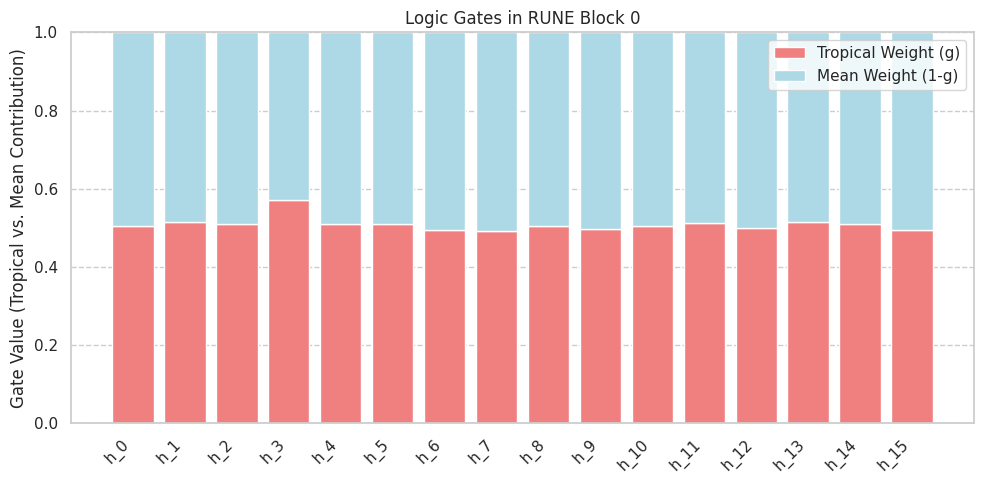

In [9]:
display(Markdown("#### `plot_gated_aggregator_gates`"))
display(Markdown("For a `GatedTropicalDifferenceAggregator`, this shows the learned preference between sparse, rule-based logic (tropical `max`) and holistic, averaging logic (`mean`). A value close to 1 means the model prefers the tropical rule for that hidden feature."))

fig, ax = plt.subplots(figsize=(10, 5))
plot_gated_aggregator_gates(
    block0.gated_agg,
    feature_names=hidden_names,
    ax=ax,
    title="Logic Gates in RUNE Block 0"
)
plt.show()

### 4.3. High-Level and Holistic Interpretation
These functions provide a bigger-picture view of the model's behavior.

#### `plot_feature_interaction_graph`

Creates a graph where nodes are input features and edges represent an important learned comparison. This provides a clear, high-level map of the model's logic. Requires `networkx`.

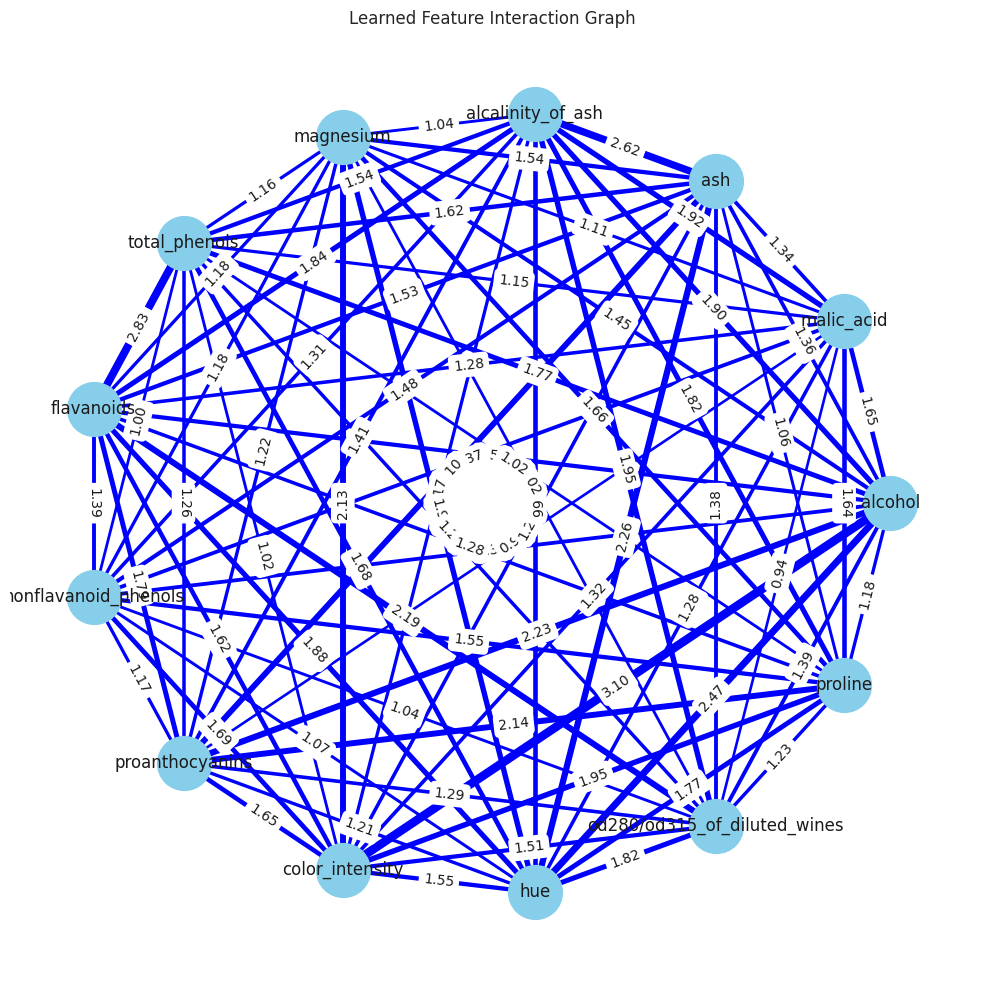

In [10]:
display(Markdown("#### `plot_feature_interaction_graph`"))
display(Markdown("Creates a graph where nodes are input features and edges represent an important learned comparison. This provides a clear, high-level map of the model's logic. Requires `networkx`."))

fig, ax = plt.subplots(figsize=(10, 10))
try:
    plot_feature_interaction_graph(
        pdn_model.pairwise_diff_layer,
        feature_names=feature_names,
        ax=ax,
        threshold=0.5 # Show only strong interactions
    )
    plt.show()
except ImportError:
    display(Markdown("_`networkx` is not installed. Skipping this plot._"))
except Exception as e:
    print(f"Could not generate graph: {e}")

#### `plot_final_layer_contributions`

For a single sample (true class: 0), this function calculates which features *entering the final layer* had the most impact on the prediction. A positive contribution pushed the score towards the predicted class, while a negative one pushed it away.

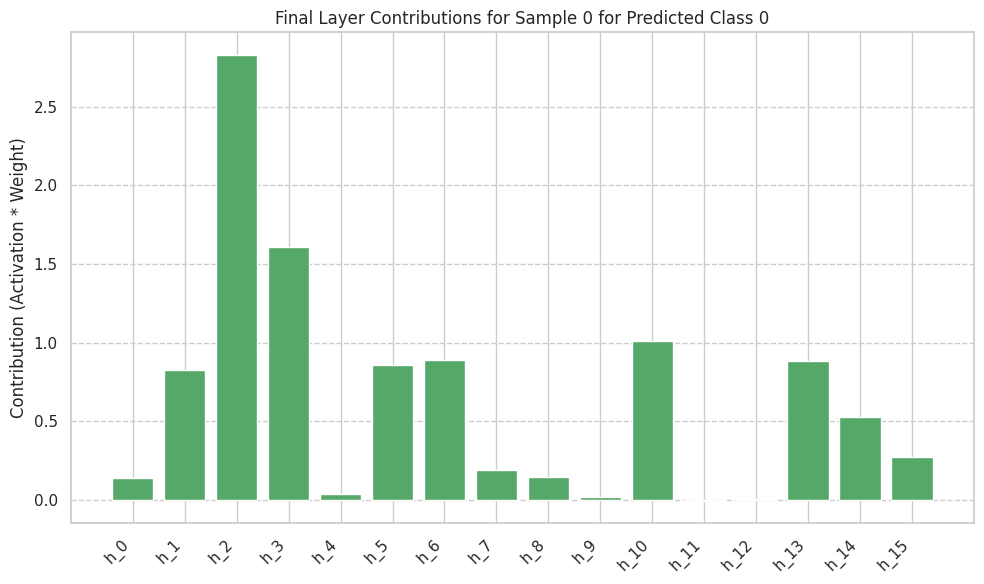

In [11]:
# Prepare a sample for single-instance explanations
sample_idx = 0
x_sample_tensor = torch.tensor(X_test[sample_idx], dtype=torch.float32).to(DEVICE)
true_label = y_test[sample_idx]

display(Markdown("#### `plot_final_layer_contributions`"))
display(Markdown(f"For a single sample (true class: {true_label}), this function calculates which features *entering the final layer* had the most impact on the prediction. A positive contribution pushed the score towards the predicted class, while a negative one pushed it away."))

fig, ax = plt.subplots(figsize=(10, 6))
plot_final_layer_contributions(
    irn_model,
    x_sample_tensor,
    feature_names=[f"h_{i}" for i in range(irn_model.rune_blocks[0].gated_agg.dim)],
    ax=ax,
    title=f"Final Layer Contributions for Sample {sample_idx}"
)
plt.show()

### 4.4. Rule and Path Tracing
These functions produce textual or dictionary-based reports of the model's reasoning process.

In [12]:
display(Markdown("#### `analyze_tropical_dominance`"))
display(Markdown("A low-level function that, for a given input, calculates which `(x_i - x_j)` terms inside a `TropicalDifferenceAggregator` were most dominant in the soft-max calculation. This is the core of rule extraction."))

# We analyze the dominance inside the first block using the hidden state after the input projection
h0 = irn_model.input_projection(x_sample_tensor.unsqueeze(0))
dominance_report = analyze_tropical_dominance(
    block0.gated_agg.tropical_agg,
    h0,
    top_k=2,
    feature_names=hidden_names
)
print("Dominant Tropical Terms Report for Block 0:")
print(json.dumps(dominance_report, indent=2))

#### `analyze_tropical_dominance`

A low-level function that, for a given input, calculates which `(x_i - x_j)` terms inside a `TropicalDifferenceAggregator` were most dominant in the soft-max calculation. This is the core of rule extraction.

Dominant Tropical Terms Report for Block 0:
{
  "h_0": [
    [
      "(h_0 - h_10)",
      0.10809344053268433
    ],
    [
      "(h_0 - h_9)",
      0.10588601231575012
    ]
  ],
  "h_1": [
    [
      "(h_1 - h_5)",
      0.11636534333229065
    ],
    [
      "(h_1 - h_13)",
      0.08827012032270432
    ]
  ],
  "h_2": [
    [
      "(h_2 - h_4)",
      0.9981421232223511
    ],
    [
      "(h_2 - h_3)",
      0.000367937347618863
    ]
  ],
  "h_3": [
    [
      "(h_3 - h_2)",
      0.9999966621398926
    ]
  ],
  "h_4": [
    [
      "(h_4 - h_2)",
      0.9978538155555725
    ],
    [
      "(h_4 - h_1)",
      0.0001885630190372467
    ]
  ],
  "h_5": [
    [
      "(h_5 - h_1)",
      0.22930198907852173
    ],
    [
      "(h_5 - h_7)",
      0.06465008109807968
    ]
  ],
  "h_6": [
    [
      "(h_6 - h_13)",
      0.08964207768440247
    ],
    [
      "(h_6 - h_14)",
      0.08507997542619705
    ]
  ],
  "h_7": [
    [
      "(h_7 - h_6)",
      0.10020490735769272
 

In [13]:
display(Markdown("#### `trace_decision_path`"))
display(Markdown("The most powerful function. It acts as a dispatcher, providing a complete, step-by-step reasoning trace for a prediction. For an `InterpretableRuneNet`, it combines dominance analysis and final layer contributions into one report."))

path_report_irn = trace_decision_path(
    irn_model,
    x_sample_tensor,
    top_k=2,
    feature_names=feature_names
)
print("Full Decision Path for InterpretableRuneNet:")
print(json.dumps(path_report_irn, indent=2))

#### `trace_decision_path`

The most powerful function. It acts as a dispatcher, providing a complete, step-by-step reasoning trace for a prediction. For an `InterpretableRuneNet`, it combines dominance analysis and final layer contributions into one report.

Full Decision Path for InterpretableRuneNet:
{
  "InputProjection": "Input projected to internal dimension.",
  "RUNEBlock_0": {
    "DominantTropicalTerms": {
      "Proj_0": [
        [
          "(Proj_0 - Proj_10)",
          0.10809344053268433
        ],
        [
          "(Proj_0 - Proj_9)",
          0.10588601231575012
        ]
      ],
      "Proj_1": [
        [
          "(Proj_1 - Proj_5)",
          0.11636534333229065
        ],
        [
          "(Proj_1 - Proj_13)",
          0.08827012032270432
        ]
      ],
      "Proj_2": [
        [
          "(Proj_2 - Proj_4)",
          0.9981421232223511
        ],
        [
          "(Proj_2 - Proj_3)",
          0.000367937347618863
        ]
      ],
      "Proj_3": [
        [
          "(Proj_3 - Proj_2)",
          0.9999966621398926
        ]
      ],
      "Proj_4": [
        [
          "(Proj_4 - Proj_2)",
          0.9978538155555725
        ],
        [
          "(Proj_4 - Proj_1)",
          0.000188563

### 4.5. Interpreting `PrototypeRuneNet`
This model type has its own specialized, highly intuitive interpretation methods focused on case-based reasoning.

#### `plot_prototypes_with_tsne`

Visualizes the learned prototype 'cases' (red 'X's) in the same 2D space as the real data points. This helps us understand if the model has learned meaningful archetypes that are representative of the data clusters.

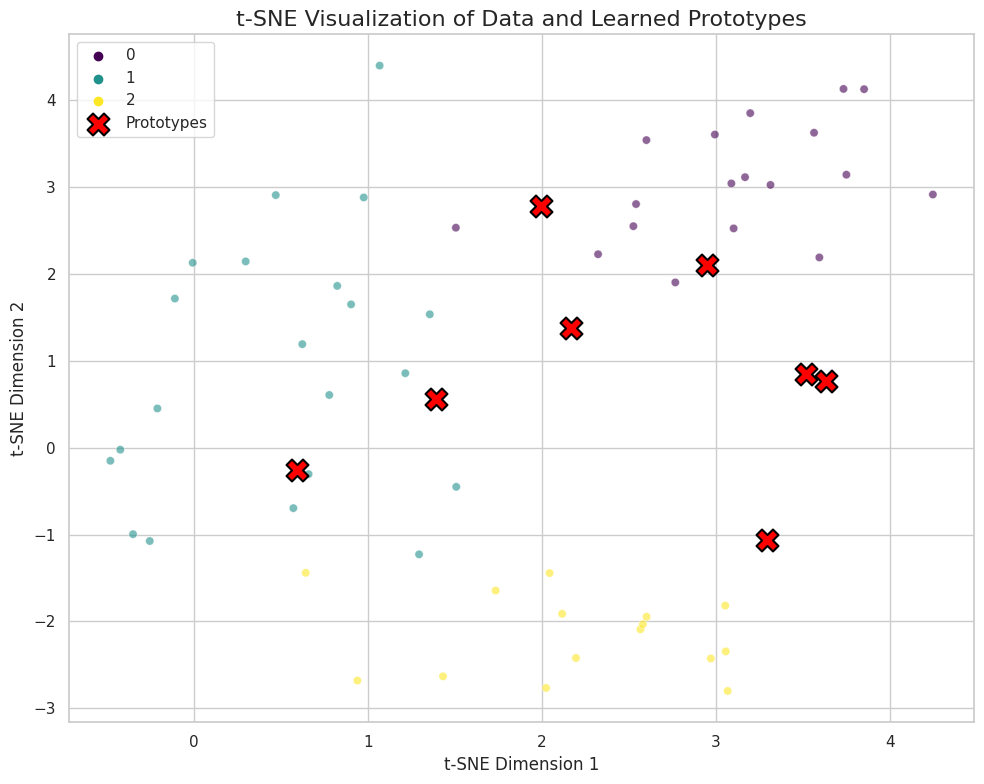

In [14]:
display(Markdown("#### `plot_prototypes_with_tsne`"))
display(Markdown("Visualizes the learned prototype 'cases' (red 'X's) in the same 2D space as the real data points. This helps us understand if the model has learned meaningful archetypes that are representative of the data clusters."))

fig, ax = plt.subplots(figsize=(10, 8))
plot_prototypes_with_tsne(proto_model, X_test, y_test, ax=ax)
plt.show()

#### `analyze_prototype_prediction`

Provides a detailed breakdown of a single prediction. It shows which prototype the sample was most similar to and gives a feature-by-feature comparison between the sample and that 'ideal case'.

**Sample Analysis**
- True Class: `0`
- Predicted Class: `0`

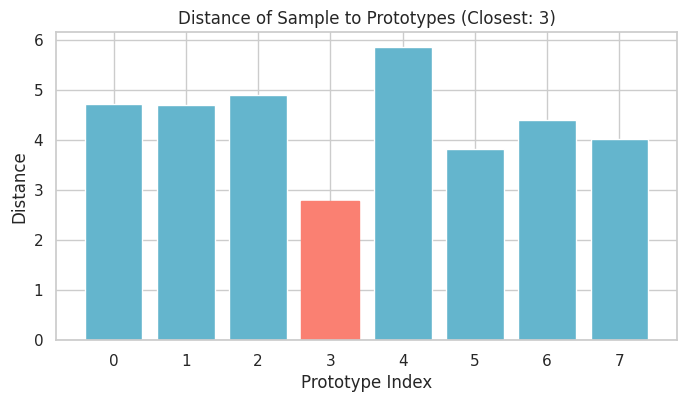

**Feature Comparison with Closest Prototype (3)**

,Feature,Prototype_Value,Sample_Value
0,alcohol,-0.507035,0.252582
1,malic_acid,0.165355,0.069135
2,ash,1.132595,1.143582
3,alcalinity_of_ash,-0.210666,-0.316772
4,magnesium,0.636506,0.063252
5,total_phenols,0.682497,0.811689
6,flavanoids,0.167367,1.296041
7,nonflavanoid_phenols,-0.128226,-0.511472
8,proanthocyanins,0.585418,2.089053
9,color_intensity,-0.514285,0.289153


In [15]:
display(Markdown("#### `analyze_prototype_prediction`"))
display(Markdown(f"Provides a detailed breakdown of a single prediction. It shows which prototype the sample was most similar to and gives a feature-by-feature comparison between the sample and that 'ideal case'."))

# Use the same sample as before
analysis_report_proto = analyze_prototype_prediction(
    proto_model,
    torch.tensor(X_test[sample_idx], dtype=torch.float32),
    feature_names=feature_names,
    top_k=1
)

pred_class = analysis_report_proto['prediction']
display(Markdown(f"**Sample Analysis**\n- True Class: `{true_label}`\n- Predicted Class: `{pred_class}`"))

# Show distances
closest_idx = analysis_report_proto['closest_prototypes'][0]['index']
plt.figure(figsize=(8, 4))
plt.bar(range(len(analysis_report_proto['distances'])), analysis_report_proto['distances'], color='c')
plt.gca().get_children()[closest_idx].set_color('salmon')
plt.title(f"Distance of Sample to Prototypes (Closest: {closest_idx})")
plt.xlabel("Prototype Index")
plt.ylabel("Distance")
plt.show()

# Show feature comparison dataframe
display(Markdown(f"**Feature Comparison with Closest Prototype ({closest_idx})**"))
display(analysis_report_proto['closest_prototypes'][0]['feature_comparison'].style.bar(align='mid', color=['#d65f5f', '#5fba7d']))

#### `trace_decision_path` on `PrototypeRuneNet`
As a final demonstration, we show that `trace_decision_path` correctly dispatches to the prototype analysis when given a `PrototypeRuneNet`.

In [16]:
display(Markdown("#### `trace_decision_path` (PrototypeRuneNet Dispatch)"))
display(Markdown("Calling the universal `trace_decision_path` on our prototype model automatically triggers the case-based analysis, providing the same rich report as `analyze_prototype_prediction`."))

# This call will internally use `analyze_prototype_prediction`
path_report_proto = trace_decision_path(
    proto_model,
    torch.tensor(X_test[sample_idx], dtype=torch.float32),
    feature_names=feature_names,
    top_k=1
)

# We don't print the whole thing again, just confirm it worked
print("Report generated successfully. Keys:", list(path_report_proto.keys()))
assert 'closest_prototypes' in path_report_proto

#### `trace_decision_path` (PrototypeRuneNet Dispatch)

Calling the universal `trace_decision_path` on our prototype model automatically triggers the case-based analysis, providing the same rich report as `analyze_prototype_prediction`.

Dispatching to `analyze_prototype_prediction` for PrototypeRuneNet.
Report generated successfully. Keys: ['prediction', 'distances', 'closest_prototypes']
